In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import numpy as np
import pandas as pd

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, rnn_cell='lstm', dropout=0.5, bidirectional=True):
        super(Encoder, self).__init__()  # Initialize the Encoder class.
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size)  # Define an embedding layer.
        self.dropout = nn.Dropout(dropout)  # Apply dropout regularization.
        self.hidden_size = hidden_size  # Set the hidden size.
        self.num_layers = num_layers  # Set the number of layers.
        self.bidirectional = bidirectional  # Specify if the RNN is bidirectional.
        
        rnn_hidden_size = hidden_size // 2 if bidirectional else hidden_size  # Calculate the hidden size of each direction.

        # Choose the appropriate RNN cell based on the input.
        if rnn_cell.lower() == 'lstm':
            self.rnn = nn.LSTM(embedding_size, rnn_hidden_size, num_layers, batch_first=True, dropout=(0 if num_layers == 1 else dropout), bidirectional=bidirectional)
        elif rnn_cell.lower() == 'gru':
            self.rnn = nn.GRU(embedding_size, rnn_hidden_size, num_layers, batch_first=True, dropout=(0 if num_layers == 1 else dropout), bidirectional=bidirectional)
        else:
            self.rnn = nn.RNN(embedding_size, rnn_hidden_size, num_layers, batch_first=True, dropout=(0 if num_layers == 1 else dropout), bidirectional=bidirectional)
    
    def forward(self, x):
        embedded = self.embedding(x)  # Embed the input.
        embedded = self.dropout(embedded)  # Apply dropout to the embedded input.
        outputs, hidden = self.rnn(embedded)  # Pass the embedded input through the RNN.

        if self.bidirectional:  # If bidirectional, concatenate hidden states appropriately.
            if isinstance(hidden, tuple):  # If LSTM, concatenate both hidden and cell states.
                h_n, c_n = hidden
#                 print('enc h bef dir',h_n.shape)
#                 print('enc c bef dir',c_n.shape)
                h_n = torch.cat((h_n[0::2], h_n[1::2]), dim=2)  # Concatenate hidden states.
                c_n = torch.cat((c_n[0::2], c_n[1::2]), dim=2)  # Concatenate cell states.
#                 print('enc h af dir',h_n.shape)
#                 print('enc c af dir',c_n.shape)
                hidden = (h_n, c_n)  # Update hidden states.
            else:  # If GRU or RNN, concatenate hidden states only.
#                 print('enc hidd bef dir',hidden.shape)
                hidden = torch.cat((hidden[0::2], hidden[1::2]), dim=2)  # Concatenate hidden states.
#                 print('after dir enc:',hidden.shape)

        return outputs, hidden  # Return RNN outputs and hidden states.

In [3]:
class Attention(nn.Module):
    def __init__(self, hidden_size, rnn_cell):
        super(Attention, self).__init__()  # Initialize the Attention class.
        self.attn = nn.Linear(hidden_size * 2, hidden_size)  # Define a linear layer for attention calculation.
        self.v = nn.Parameter(torch.rand(hidden_size))  # Define a learnable parameter v.
        self.rnn_cell = rnn_cell  # Store the type of RNN cell used.

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.size(1)  # Get the number of timesteps.
#         print(hidden.shape) 
        if self.rnn_cell == 'lstm':
            hidden = hidden[-1]  # Extract the last hidden state if LSTM.
        else:
            hidden = hidden  # Keep the hidden state if not LSTM.
        h = hidden.unsqueeze(1).repeat(1, timestep, 1)  # Repeat hidden state for each timestep.
#         print('h',h.shape)
        encoder_outputs = encoder_outputs.permute(0, 1, 2)  # Change encoder_outputs shape.
#         print('encoder_outputs',encoder_outputs.shape)
        attn_energies = self.score(h, encoder_outputs)  # Calculate attention energies.
#         print('attn_energies',attn_energies.shape) 
        return F.softmax(attn_energies, dim=1).unsqueeze(1)  # Apply softmax and return attention weights.

    def score(self, hidden, encoder_outputs):
#         print('hidden',hidden.shape) 
#         print('encoder_outputs',encoder_outputs.shape)
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2)))  # Calculate attention energy.
#         print('energy',energy.shape)
        energy = energy.permute(0, 2, 1)  # Change energy shape.
#         print('energy',energy.shape)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)  # Repeat v for batch size.
#         print('v',v.shape)
        energy = torch.bmm(v, energy)  # Calculate energy.
#         print('energy',energy.shape)
        return energy.squeeze(1)  # Return squeezed energy.

In [4]:
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, num_layers, encoder_num_layers, attention, rnn_cell='lstm', dropout=0.5, bidirectional=True):
        super(Decoder, self).__init__()  # Initialize the Decoder class.
        self.embedding = nn.Embedding(num_embeddings=output_size, embedding_dim=embedding_size)  # Define an embedding layer.
        self.dropout = nn.Dropout(dropout)  # Apply dropout regularization.
        self.output_size = output_size  # Set the output size.
        self.hidden_size = hidden_size * encoder_num_layers if bidirectional else hidden_size  # Adjust hidden size based on bidirectionality.
        self.num_layers = num_layers  # Set the number of layers.
        self.attention = attention  # Store the attention mechanism.
        
        # Choose the appropriate RNN cell based on the input.
        if rnn_cell.lower() == 'lstm':
            self.rnn = nn.LSTM(embedding_size + hidden_size * encoder_num_layers, self.hidden_size, num_layers, batch_first=True, dropout=(0 if num_layers == 1 else dropout))
        elif rnn_cell.lower() == 'gru':
            self.rnn = nn.GRU(embedding_size + hidden_size * encoder_num_layers, self.hidden_size, num_layers, batch_first=True, dropout=(0 if num_layers == 1 else dropout))
        else:
            self.rnn = nn.RNN(embedding_size + hidden_size * encoder_num_layers, self.hidden_size, num_layers, batch_first=True, dropout=(0 if num_layers == 1 else dropout))
        
        self.fc = nn.Linear(self.hidden_size, output_size)  # Define a fully connected layer for the output.
        
    def forward(self, x, hidden, encoder_outputs):
        x = x.unsqueeze(1)  # Add a dimension for the batch size.
        embedded = self.dropout(self.embedding(x))  # Embed the input and apply dropout.
        
        attn_weights = self.attention(hidden[-1], encoder_outputs)  # Calculate attention weights.
        context = attn_weights.bmm(encoder_outputs)  # Compute the context vector.
        rnn_input = torch.cat((embedded, context), 2)  # Concatenate the embedded input and context vector.
        
        output, hidden = self.rnn(rnn_input, hidden)  # Pass the concatenated input through the RNN.
        output = self.fc(self.dropout(output.squeeze(1)))  # Apply dropout, squeeze the output, and pass it through the fully connected layer.
        
        return output, hidden, attn_weights  # Return the output, hidden state, and attention weights.

In [5]:
class Seq_to_Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq_to_Seq, self).__init__()  # Initialize the Seq_to_Seq class.
        self.encoder = encoder  # Set the encoder.
        self.decoder = decoder  # Set the decoder.

    def forward(self, source, target, teaching_force_ratio=0.5):
        batch_size = source.size(0)  # Get the batch size.
        target_len = target.size(1)  # Get the length of the target sequence.
        target_vocab_size = self.decoder.output_size  # Get the size of the target vocabulary.
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(source.device)  # Initialize the output tensor.
        attention_weights = []  # List to store attention weights.
        encoder_outputs, encoder_hidden = self.encoder(source)  # Pass the source through the encoder.
        
        if isinstance(encoder_hidden, tuple):  # If the encoder uses LSTM, handle the hidden and cell states.
            h_n, c_n = encoder_hidden
            if self.encoder.bidirectional:  # If the encoder is bidirectional, concatenate the hidden states.
                h_n = torch.cat([h_n[i:i+1] for i in range(0, h_n.shape[0], 2)] + [h_n[i:i+1] for i in range(1, h_n.shape[0], 2)], dim=2)
                c_n = torch.cat([c_n[i:i+1] for i in range(0, c_n.shape[0], 2)] + [c_n[i:i+1] for i in range(1, c_n.shape[0], 2)], dim=2)
            
            if h_n.size(0) < self.decoder.num_layers:  # Adjust hidden and cell states to match the decoder layers.
                zero_h = torch.zeros(self.decoder.num_layers - h_n.size(0), batch_size, self.encoder.num_layers * self.encoder.hidden_size, device=h_n.device)
                zero_c = torch.zeros(self.decoder.num_layers - c_n.size(0), batch_size, self.encoder.num_layers * self.encoder.hidden_size, device=c_n.device)
                h_n = torch.cat([h_n, zero_h], dim=0)
                c_n = torch.cat([c_n, zero_c], dim=0)

            encoder_hidden = (h_n[:self.decoder.num_layers], c_n[:self.decoder.num_layers])  # Set encoder hidden state for decoder.
        else:
            h_n = encoder_hidden  # If the encoder uses GRU or RNN, handle the hidden state.
            if self.encoder.bidirectional:  # If the encoder is bidirectional, concatenate the hidden states.
                h_n = torch.cat([h_n[i:i+1] for i in range(0, h_n.shape[0], 2)] + [h_n[i:i+1] for i in range(1, h_n.shape[0], 2)], dim=2)
            
            if h_n.size(0) < self.decoder.num_layers:  # Adjust hidden state to match the decoder layers.
                zero_h = torch.zeros(self.decoder.num_layers - h_n.size(0), batch_size, self.encoder.num_layers * self.encoder.hidden_size, device=encoder_hidden.device)
                h_n = torch.cat([h_n, zero_h], dim=0)
            encoder_hidden = h_n[:self.decoder.num_layers]  # Set encoder hidden state for decoder.
        
        decoder_input = target[:, 0]  # Initialize the decoder input with the start token.
                    
        for t in range(1, target_len):  # Iterate over each time step.
            decoder_output, encoder_hidden, attn_weights = self.decoder(decoder_input, encoder_hidden, encoder_outputs)  # Pass through the decoder.
            attention_weights.append(attn_weights)  # Store attention weights.
            outputs[:, t] = decoder_output  # Store the decoder output.
            teacher_force = torch.rand(1) < teaching_force_ratio  # Determine if we should use teacher forcing.
            top1 = decoder_output.argmax(1)  # Get the highest predicted token.
            decoder_input = target[:, t] if teacher_force else top1  # Decide the next input based on teacher forcing.

        attention_weights = torch.stack(attention_weights, dim=1)  # Stack attention weights for all time steps.
        return outputs, attention_weights  # Return the final outputs and attention weights.

In [6]:
INPUT_DIM = 100  # Define the input dimension size.
OUTPUT_DIM = 100  # Define the output dimension size.
ENC_EMB_DIM = 64  # Set the embedding dimension size for the encoder.
DEC_EMB_DIM = 64  # Set the embedding dimension size for the decoder.
HID_DIM = 512  # Set the hidden dimension size for the RNN.
ENC_LAYERS = 1  # Set the number of layers for the encoder.
DEC_LAYERS = 1  # Set the number of layers for the decoder.
ENC_RNN_CELL = 'lstm'  # Choose LSTM as the RNN cell type for the encoder.
DEC_RNN_CELL = 'lstm'  # Choose LSTM as the RNN cell type for the decoder.

# Initialize the encoder, attention mechanism, and decoder with the specified parameters.
encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_LAYERS, ENC_RNN_CELL, dropout=0.3, bidirectional=True)
attention = Attention(HID_DIM, ENC_RNN_CELL)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_LAYERS, encoder.num_layers, attention, DEC_RNN_CELL, dropout=0.3, bidirectional=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to GPU if available, otherwise CPU.
print(f"Using device: {device}")  # Print the device being used.
model = Seq_to_Seq(encoder, decoder).to(device)  # Initialize the Seq_to_Seq model and move it to the specified device.
print(model)  # Print the model architecture.

Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 64)
    (dropout): Dropout(p=0.3, inplace=False)
    (rnn): LSTM(64, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 64)
    (dropout): Dropout(p=0.3, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(576, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)


In [7]:
# # Define a function to create a vocabulary set from a given text
# def create_vocab(text):
#     # Create a set of unique characters found in the text
#     # Each word in the text is processed to extract its characters
#     vocab = set(char for word in text for char in word)
#     # Add a padding token to the vocabulary
#     vocab.add('<pad>')
#     # Add a start-of-sequence token to the vocabulary
#     vocab.add('<sos>')  # Start of sequence token
#     # Add an end-of-sequence token to the vocabulary
#     vocab.add('<eos>')  # End of sequence token
#     # Return the complete set of vocabulary items
#     return vocab

In [8]:
# First, let's modify the load_data function to ensure correct column ordering
def load_data(path):
    # Make sure we're correctly identifying which column is which
    df = pd.read_csv(path, header=None, names=['telugu', 'transliteration', 'score'], sep='\t')
    
    # Check a few samples to verify column ordering
    #print("Sample data:")
    #print(df.head(3))
    
    # Return the transliteration and Telugu columns in the right order
    return df['transliteration'], df['telugu']  # Note the order - transliteration first, Telugu second

In [9]:
# Load Telugu and transliteration training data from specified path
trans_train, tel_train = load_data('/kaggle/input/dakshina/te.translit.sampled.train.tsv')

In [10]:
print(trans_train)

0             amkita
1             ankita
2            ankitha
3            ankitam
4           ankitham
            ...     
58545    huumanities
58546          human
58547         humane
58548        huumane
58549         hyuman
Name: transliteration, Length: 58550, dtype: object


In [11]:
print(tel_train)

0               అంకిత
1               అంకిత
2               అంకిత
3              అంకితం
4              అంకితం
             ...     
58545    హ్యుమానిటీస్
58546         హ్యూమన్
58547         హ్యూమన్
58548         హ్యూమన్
58549         హ్యూమన్
Name: telugu, Length: 58550, dtype: object


In [12]:
# Define a function to create a vocabulary set from a given text
def create_vocab(text):
    # Create a set of unique characters found in the text
    # First convert all items to strings and skip any NaN values
    vocab = set()
    for word in text:
        if pd.notna(word):  # Skip NaN values
            for char in str(word):  # Convert to string to handle any non-string values
                vocab.add(char)
    
    # Add special tokens to the vocabulary
    vocab.add('<pad>')
    vocab.add('<sos>')  # Start of sequence token
    vocab.add('<eos>')  # End of sequence token
    
    # Return the complete set of vocabulary items
    return vocab

# Create a vocabulary from the transliteration training data
trans_vocab = create_vocab(trans_train)
# Create a vocabulary from the Telugu training data
tel_vocab = create_vocab(tel_train)

In [13]:
print(len(trans_vocab))
print(trans_vocab)

29
{'b', 'f', 'u', '<pad>', 'd', 'p', 'z', 'e', 'o', 'l', 'v', 'c', 'i', 'q', 's', 'h', 'm', 'r', '<eos>', 't', 'w', 'a', 'k', 'n', '<sos>', 'x', 'j', 'g', 'y'}


In [14]:
print(len(tel_vocab))
print(tel_vocab)

66
{'ఒ', 'ర', 'ణ', 'అ', 'ూ', 'ఫ', 'ఉ', 'థ', '<pad>', '్', 'ః', 'ఆ', 'ఞ', 'ఈ', 'ౌ', 'ి', 'న', 'ఱ', 'క', 'ఓ', 'త', 'ం', 'ఇ', 'మ', 'ె', 'గ', 'ో', 'ఎ', 'ొ', 'డ', 'ృ', 'ఐ', '\u200c', 'ఘ', 'వ', 'శ', 'ష', 'ే', 'ళ', 'ఋ', 'చ', 'ద', 'ప', 'ఖ', '<eos>', 'హ', 'ై', 'ఛ', 'ఏ', 'ల', 'భ', 'ీ', 'బ', 'ు', 'ఊ', 'య', 'ఔ', 'ధ', '<sos>', 'ఠ', 'ా', 'ట', 'స', 'ఝ', 'జ', 'ఢ'}


In [15]:
# Map each token in the trans vocabulary to a unique index
trans_token_to_index = {token: index for index, token in enumerate(sorted(trans_vocab))}
# Map each token in the telugu vocabulary to a unique index
tel_token_to_index = {token: index for index, token in enumerate(sorted(tel_vocab))}

In [16]:
# Print the dictionary mapping trans tokens to indices
print(trans_token_to_index)

{'<eos>': 0, '<pad>': 1, '<sos>': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28}


In [17]:
# Print the dictionary mapping telugu tokens to indices
print(tel_token_to_index)

{'<eos>': 0, '<pad>': 1, '<sos>': 2, 'ం': 3, 'ః': 4, 'అ': 5, 'ఆ': 6, 'ఇ': 7, 'ఈ': 8, 'ఉ': 9, 'ఊ': 10, 'ఋ': 11, 'ఎ': 12, 'ఏ': 13, 'ఐ': 14, 'ఒ': 15, 'ఓ': 16, 'ఔ': 17, 'క': 18, 'ఖ': 19, 'గ': 20, 'ఘ': 21, 'చ': 22, 'ఛ': 23, 'జ': 24, 'ఝ': 25, 'ఞ': 26, 'ట': 27, 'ఠ': 28, 'డ': 29, 'ఢ': 30, 'ణ': 31, 'త': 32, 'థ': 33, 'ద': 34, 'ధ': 35, 'న': 36, 'ప': 37, 'ఫ': 38, 'బ': 39, 'భ': 40, 'మ': 41, 'య': 42, 'ర': 43, 'ఱ': 44, 'ల': 45, 'ళ': 46, 'వ': 47, 'శ': 48, 'ష': 49, 'స': 50, 'హ': 51, 'ా': 52, 'ి': 53, 'ీ': 54, 'ు': 55, 'ూ': 56, 'ృ': 57, 'ె': 58, 'ే': 59, 'ై': 60, 'ొ': 61, 'ో': 62, 'ౌ': 63, '్': 64, '\u200c': 65}


In [18]:
# Define a Dataset class for handling trans and telugu word pairs
class DakshinaDataset(Dataset):
    def __init__(self, trans_words, tel_words, trans_token_to_index, tel_token_to_index):
        # Store the lists of trans and telugu words
        self.trans_words = trans_words
        self.tel_words = tel_words
        # Store the dictionaries that map characters to indices for both languages
        self.trans_token_to_index = trans_token_to_index
        self.tel_token_to_index = tel_token_to_index

    def __len__(self):
        # Return the number of word pairs in the dataset
        return len(self.trans_words)

    def __getitem__(self, index):
        # Fetching the trans and telugu words at the specified index
        trans_word = self.trans_words.iloc[index]
#         print(trans_word)
        tel_word = self.tel_words.iloc[index]
#         print(tel_word)
        # Convert the trans word into indices using the trans_token_to_index mapping
        trans_indices = [trans_token_to_index[char] for char in trans_word]
#         print(trans_indices)
        # Convert the tekugu word into indices, adding <sos> and <eos> tokens
        tel_indices = [tel_token_to_index['<sos>']] + [tel_token_to_index[char] for char in tel_word] + [tel_token_to_index['<eos>']]
#         print(tel_indices)
        # Return the indices as tensor objects
        return torch.tensor(trans_indices, dtype=torch.long), torch.tensor(tel_indices, dtype=torch.long)

In [19]:
# Define a function for padding sequences and packing batches
# packet_fn specifies a function to control how batches are created from the individual data items
def packet_fn(batch):
    # Unzip the batch to separate trans and telugu indices
    trans, tel = zip(*batch)
#     print(trans , telugu)
    # Pad the sequences of trans indices
    trans_padded = pad_sequence(trans, batch_first=True, padding_value=trans_token_to_index['<pad>'])
#     print(trans_padded)
    # Pad the sequences of telugu indices
    tel_padded = pad_sequence(tel, batch_first=True, padding_value=tel_token_to_index['<pad>'])
#     print(tel_padded)
    # Return the padded batches
    return trans_padded, tel_padded

In [20]:
# Load training data into the DakshinaDataset
train_dataset = DakshinaDataset(trans_train, tel_train, trans_token_to_index, tel_token_to_index)
# Create a DataLoader to batch and shuffle the dataset
# packet_fn specifies a function to control how batches are created from the individual data items
train_loader = DataLoader(train_dataset, batch_size = 64, collate_fn=packet_fn, shuffle=True)

In [21]:
print(len(train_dataset))

58550


In [22]:
print(train_dataset[4000])

(tensor([ 3,  6, 10, 11, 18,  3, 22, 27,  3]), tensor([ 2,  6, 35, 53, 37, 32, 64, 42,  0]))


In [23]:
# Define a word accuracy function for word-level accuracy
def word_accuracy(outputs, targets, ignore_index):
    # Assuming outputs and targets are batched sequences of token indices
    # Ignoring <pad> tokens as specified by `ignore_index`
    correct = 0  # Initialize the count of correct predictions.
    total = 0  # Initialize the total number of sequences.
    for out, tar in zip(outputs, targets):  # Iterate over each output and target pair.
        # Ignoring padding in accuracy calculation
#         print('out bef pad:',out)  # Uncomment to print the output before removing padding.
#         print('tar:',tar)  # Uncomment to print the target.
        out = out[out != ignore_index]  # Remove padding tokens from the output.
        tar = tar[tar != ignore_index]  # Remove padding tokens from the target.
        ignore_index_eos = 0  # Define an ignore index for end of sequence.
        out = out[out != ignore_index_eos]  # Remove end of sequence tokens from the output.
        tar = tar[tar != ignore_index_eos]  # Remove end of sequence tokens from the target.
#         print('out aft pad:',out)  # Uncomment to print the output after removing padding.
#         print('tar:',tar)  # Uncomment to print the target after removing padding.
        if torch.equal(out, tar):  # Check if the processed output and target are identical.
            correct += 1  # Increment the correct count.
#             print('correct:',correct)  # Uncomment to print the correct count.
        total += 1  # Increment the total count.
#         print('total:',total)  # Uncomment to print the total count.
    return correct / total if total > 0 else 0  # Calculate and return the accuracy.

In [24]:
def train(model, iterator, optimizer, criterion, clip, device, ignore_index):
    model.train()  # Set the model to training mode.
    epoch_loss = 0  # Initialize the epoch loss.
    epoch_acc = 0  # Initialize the epoch accuracy.
    epoch_attention_weights = []  # List to store attention weights
    
    for source, target in iterator:  # Iterate over batches of source and target sequences.
        source = source.to(device)  # Move the source sequences to the specified device.
        target = target.to(device)  # Move the target sequences to the specified device.
        
        optimizer.zero_grad()  # Reset the gradients.
        
        # Call the model's forward method to get outputs and attention weights
        output, attention_weights = model(source, target)
        
        output_dim = output.shape[-1]  # Get the output dimension.
        # Slice to ignore the <sos> token and keep sequence structure
        output = output[:, 1:, :]  # Remove the <sos> token from the output.
        target = target[:, 1:]  # Remove the <sos> token from the target.
        
        # Flatten all dimensions except for the batch dimension for loss calculation
        output_flat = output.reshape(-1, output_dim)  # Reshape the output for loss calculation.
        target_flat = target.reshape(-1)  # Reshape the target for loss calculation.
        
        loss = criterion(output_flat, target_flat)  # Calculate the loss.
        # Calculate word-by-word accuracy
        acc = word_accuracy(output.argmax(dim=2), target, ignore_index)  # Calculate the accuracy.
        
        loss.backward()  # Backpropagate the loss.
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  # Clip the gradients to prevent exploding gradients.
        optimizer.step()  # Update the model parameters.
        
        epoch_loss += loss.item()  # Accumulate the epoch loss.
        epoch_acc += acc  # Accumulate the epoch accuracy.
        epoch_attention_weights.append(attention_weights)  # Store attention weights
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_attention_weights  # Return the average loss, accuracy, and attention weights.

In [25]:
def evaluate(model, iterator, criterion, device, ignore_index):
    model.eval()  # Set the model to evaluation mode.
    epoch_loss = 0  # Initialize the epoch loss.
    epoch_acc = 0  # Initialize the epoch accuracy.
    epoch_attention_weights = []  # List to store attention weights.
    
    with torch.no_grad():  # Disable gradient calculation for evaluation.
        for source, target in iterator:  # Iterate over batches of source and target sequences.
            source = source.to(device)  # Move the source sequences to the specified device.
            target = target.to(device)  # Move the target sequences to the specified device.
            
            # Call the model's forward method to get outputs and attention weights
            output, attention_weights = model(source, target, 0)  # Set teacher forcing ratio to 0 for evaluation.
            
            output_dim = output.shape[-1]  # Get the output dimension.
            output = output[:, 1:, :]  # Remove the <sos> token from the output.
            target = target[:, 1:]  # Remove the <sos> token from the target.
            
            output_flat = output.reshape(-1, output_dim)  # Reshape the output for loss calculation.
            target_flat = target.reshape(-1)  # Reshape the target for loss calculation.
            
            loss = criterion(output_flat, target_flat)  # Calculate the loss.
            acc = word_accuracy(output.argmax(dim=2), target, ignore_index)  # Calculate the accuracy.
            
            epoch_loss += loss.item()  # Accumulate the epoch loss.
            epoch_acc += acc  # Accumulate the epoch accuracy.
            epoch_attention_weights.append(attention_weights)  # Store attention weights.
    
#     print(epoch_attention_weights.shape)  # Uncomment to print the shape of the attention weights.
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_attention_weights  # Return the average loss, accuracy, and attention weights.

In [26]:
# Load validation data by reading a TSV file
trans_valid, tel_valid = load_data('/kaggle/input/dakshina/te.translit.sampled.dev.tsv')

# Create a validation dataset using the DakshinaDataset class.
valid_dataset = DakshinaDataset(trans_valid, tel_valid, trans_token_to_index, tel_token_to_index)

# Create a DataLoader to batch and shuffle the dataset
# 'collate_fn=packet_fn' specifies a function to control how batches are created from the individual data items.
# 'shuffle=True' ensures that the data is shuffled at every epoch which helps to reduce model overfitting
valid_loader = DataLoader(valid_dataset, batch_size=64, collate_fn=packet_fn, shuffle=True)

In [27]:
print(len(trans_valid))

5683


In [28]:
# -embed_size-64-layers_enc-1-layers_dec-1-hid_size-512-cell_type-lstm-bidirectional-True-dropout-0.3-epoch-12
INPUT_DIM = 100  # Define the input dimension size.
OUTPUT_DIM = 100  # Define the output dimension size.
ENC_EMB_DIM = 64  # Set the embedding dimension size for the encoder.
DEC_EMB_DIM = 64  # Set the embedding dimension size for the decoder.
HID_DIM = 512  # Set the hidden dimension size for the RNN.
ENC_LAYERS = 1  # Set the number of layers for the encoder.
DEC_LAYERS = 1  # Set the number of layers for the decoder.
ENC_RNN_CELL = 'lstm'  # Choose LSTM as the RNN cell type for the encoder.
DEC_RNN_CELL = 'lstm'  # Choose LSTM as the RNN cell type for the decoder.

# Initialize the encoder, attention mechanism, and decoder with the specified parameters.
encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_LAYERS, ENC_RNN_CELL, dropout=0.3, bidirectional=True)
attention = Attention(HID_DIM, ENC_RNN_CELL)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_LAYERS, encoder.num_layers, attention, DEC_RNN_CELL, dropout=0.3, bidirectional=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to GPU if available, otherwise CPU.
print(f"Using device: {device}")  # Print the device being used.
model = Seq_to_Seq(encoder, decoder).to(device)  # Initialize the Seq_to_Seq model and move it to the specified device.
print(model)  # Print the model architecture.

Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 64)
    (dropout): Dropout(p=0.3, inplace=False)
    (rnn): LSTM(64, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 64)
    (dropout): Dropout(p=0.3, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(576, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)


In [29]:
# Original method (causing the error)
def __getitem__(self, index):
    # Get the transliteration and Telugu words for the current index
    trans_word = self.trans_data.iloc[index]
    tel_word = self.tel_data.iloc[index]
    
    # Convert the trans word into indices using the trans_token_to_index mapping
    trans_indices = [trans_token_to_index[char] for char in trans_word]  # Error line
    
    # Convert the telugu word into indices, adding <sos> and <eos> tokens
    tel_indices = [tel_token_to_index['<sos>']] + [tel_token_to_index[char] for char in tel_word] + [tel_token_to_index['<eos>']]
    
    # Convert lists to tensors
    return torch.tensor(trans_indices), torch.tensor(tel_indices)

In [30]:
# Completely redefine your Dataset class
class TransliterationDataset(torch.utils.data.Dataset):
    def __init__(self, trans_data, tel_data):
        self.trans_data = trans_data
        self.tel_data = tel_data
    
    def __len__(self):
        return len(self.trans_data)
    
    def __getitem__(self, index):
        # Get the transliteration and Telugu words for the current index
        trans_word = self.trans_data.iloc[index]
        tel_word = self.tel_data.iloc[index]
        
        # Handle NaN or float values by converting to string
        if pd.isna(trans_word) or not isinstance(trans_word, str):
            trans_word = str(trans_word) if not pd.isna(trans_word) else ""
            
        if pd.isna(tel_word) or not isinstance(tel_word, str):
            tel_word = str(tel_word) if not pd.isna(tel_word) else ""
        
        # Convert the transliteration word into indices
        trans_indices = []
        for char in trans_word:
            if char in trans_token_to_index:
                trans_indices.append(trans_token_to_index[char])
            else:
                # Skip unknown characters
                continue
        
        # If no valid characters were found, use a minimal valid sequence
        if not trans_indices:
            trans_indices = [trans_token_to_index.get('<pad>', 0)]
        
        # Convert the Telugu word into indices, adding <sos> and <eos> tokens
        tel_indices = [tel_token_to_index['<sos>']]
        for char in tel_word:
            if char in tel_token_to_index:
                tel_indices.append(tel_token_to_index[char])
            else:
                # Skip unknown characters
                continue
        tel_indices.append(tel_token_to_index['<eos>'])
        
        # Convert lists to tensors
        return torch.tensor(trans_indices), torch.tensor(tel_indices)

In [31]:
# Load the test data from the specified TSV file location
trans_test, tel_test = load_data('/kaggle/input/dakshina/te.translit.sampled.test.tsv')

# Create test_dataset using the DakshinaDataset class, initializing it with test data
# and corresponding token-to-index mappings for both trans and telugu scripts
test_dataset = DakshinaDataset(trans_test, tel_test, trans_token_to_index, tel_token_to_index)

# A DataLoader for the test dataset. Here, the batch size is set to 1, indicates
# that the model will process one item at a time. This is for testing to make
# detailed predictions per sample without batching effects.
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=packet_fn, shuffle=False)
# print(test_dataset[0])

In [32]:
# Define batch size
BATCH_SIZE = 32  # You can adjust this as needed

# Define a padding collate function to handle variable length sequences
def pad_collate_fn(batch):
    # Sort the batch in descending order by source length
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    
    # Get source and target sequences
    src_seqs, trg_seqs = zip(*batch)
    
    # Find length of longest sequence in batch
    src_lengths = [len(s) for s in src_seqs]
    trg_lengths = [len(t) for t in trg_seqs]
    max_src_len = max(src_lengths)
    max_trg_len = max(trg_lengths)
    
    # Pad source sequences
    src_padded = torch.zeros(len(src_seqs), max_src_len).long()
    for i, seq in enumerate(src_seqs):
        end = src_lengths[i]
        src_padded[i, :end] = seq
    
    # Pad target sequences
    trg_padded = torch.zeros(len(trg_seqs), max_trg_len).long()
    for i, seq in enumerate(trg_seqs):
        end = trg_lengths[i]
        trg_padded[i, :end] = seq
    
    # Return padded tensors and lengths
    return src_padded, trg_padded

# Create datasets
train_dataset = TransliterationDataset(trans_train, tel_train)
valid_dataset = TransliterationDataset(trans_valid, tel_valid)
test_dataset = TransliterationDataset(trans_test, tel_test)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    collate_fn=pad_collate_fn
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, 
    batch_size=BATCH_SIZE,
    collate_fn=pad_collate_fn
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,
    collate_fn=pad_collate_fn
)

In [33]:
NUM_EPOCHS = 5
CLIP = 1
optimizer = torch.optim.Adam(model.parameters())
ignore_index = tel_token_to_index['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=ignore_index).to(device)

for epoch in range(NUM_EPOCHS):
    train_loss, train_accuracy, train_attention_weights = train(model, train_loader, optimizer, criterion, CLIP, device, ignore_index)
    val_loss, val_accuracy, _ = evaluate(model, valid_loader, criterion, device, ignore_index)
    
    print(f'Epoch: {epoch+1}')
    print(f'\tTrain_Loss: {train_loss:.3f}, Train_Accuracy: {train_accuracy*100:.2f}%')
    print(f'\tVal_Loss: {val_loss:.3f},  Val_Accuracy: {val_accuracy*100:.2f}%')

Epoch: 1
	Train_Loss: 0.563, Train_Accuracy: 30.73%
	Val_Loss: 0.480,  Val_Accuracy: 50.49%
Epoch: 2
	Train_Loss: 0.231, Train_Accuracy: 53.19%
	Val_Loss: 0.424,  Val_Accuracy: 54.72%
Epoch: 3
	Train_Loss: 0.191, Train_Accuracy: 59.72%
	Val_Loss: 0.401,  Val_Accuracy: 58.11%
Epoch: 4
	Train_Loss: 0.161, Train_Accuracy: 64.51%
	Val_Loss: 0.417,  Val_Accuracy: 58.30%
Epoch: 5
	Train_Loss: 0.140, Train_Accuracy: 67.86%
	Val_Loss: 0.404,  Val_Accuracy: 60.36%


In [34]:
print(len(trans_test))

5747


In [35]:
def decode_indices(indices, index_to_token):
    # Filter out indices for padding, start-of-sequence, and end-of-sequence tokens to ensure only valid character indices are decoded
    valid_indices = [index for index in indices if index in index_to_token and index not in (tel_token_to_index['<pad>'], tel_token_to_index['<sos>'], tel_token_to_index['<eos>'])]
    # Convert each index to its corresponding character and join them to form the decoded string
    return ''.join([index_to_token[index] for index in valid_indices])

In [36]:
def predict(model, iterator, device):
    # Set the model to evaluation mode to disable dropout or batch normalization effects during inference
    model.eval()
    predictions = []
    # Disables gradient calculations for performance improvement since they are not needed in inference
    with torch.no_grad():
        for source, target in iterator:
            # Ensure the source and target tensors are on the correct device (GPU or CPU)
            source = source.to(device)
            target = target.to(device)
            # Obtain model output and attention weights without teacher forcing (i.e., the model relies entirely on its predictions)
            output, attention_weights = model(source, target, 0)
            # Get the index with the highest probability from output predictions
            output = output.argmax(2)
            # Convert tensors to CPU numpy arrays for easier manipulation and extraction
            source = source.cpu().numpy()
            output = output.cpu().numpy()
            target = target.cpu().numpy()
            attention_weights = attention_weights.cpu().numpy()
            # Store the tuple of source, decoded output predictions, and attention weights
            predictions.append((source, target, output, attention_weights))
    # Return all predictions made over the iterator
    return predictions

In [37]:
# Create dictionaries to map indices back to characters, observing the interpretation of prediction outputs
trans_index_to_token = {index: char for char, index in trans_token_to_index.items()}
tel_index_to_token = {index: char for char, index in tel_token_to_index.items()}

In [38]:
print(trans_index_to_token)

{0: '<eos>', 1: '<pad>', 2: '<sos>', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q', 20: 'r', 21: 's', 22: 't', 23: 'u', 24: 'v', 25: 'w', 26: 'x', 27: 'y', 28: 'z'}


In [39]:
print(tel_index_to_token)

{0: '<eos>', 1: '<pad>', 2: '<sos>', 3: 'ం', 4: 'ః', 5: 'అ', 6: 'ఆ', 7: 'ఇ', 8: 'ఈ', 9: 'ఉ', 10: 'ఊ', 11: 'ఋ', 12: 'ఎ', 13: 'ఏ', 14: 'ఐ', 15: 'ఒ', 16: 'ఓ', 17: 'ఔ', 18: 'క', 19: 'ఖ', 20: 'గ', 21: 'ఘ', 22: 'చ', 23: 'ఛ', 24: 'జ', 25: 'ఝ', 26: 'ఞ', 27: 'ట', 28: 'ఠ', 29: 'డ', 30: 'ఢ', 31: 'ణ', 32: 'త', 33: 'థ', 34: 'ద', 35: 'ధ', 36: 'న', 37: 'ప', 38: 'ఫ', 39: 'బ', 40: 'భ', 41: 'మ', 42: 'య', 43: 'ర', 44: 'ఱ', 45: 'ల', 46: 'ళ', 47: 'వ', 48: 'శ', 49: 'ష', 50: 'స', 51: 'హ', 52: 'ా', 53: 'ి', 54: 'ీ', 55: 'ు', 56: 'ూ', 57: 'ృ', 58: 'ె', 59: 'ే', 60: 'ై', 61: 'ొ', 62: 'ో', 63: 'ౌ', 64: '్', 65: '\u200c'}


In [40]:
# Taking the prediction function to generate outputs for all samples in the test_loader
test_predictions = predict(model, test_loader, device)
# print(test_predictions[1])
# Loop through the list of tuples containing source and output indices from the test predictions
for source_indices, target_indices, output_indices, attention_weights in test_predictions:
    # Iterate through each example in the batch. This is necessary as batches may contain multiple examples
    for i in range(source_indices.shape[0]):
        # Decode the source indices to their corresponding text using the mapping dictionary for trans script
        input_text = decode_indices(source_indices[i], trans_index_to_token)
        
        target_text = decode_indices(target_indices[i], tel_index_to_token)

        # Decode the output indices to their corresponding text using the mapping dictionary for telugu script
        predicted_text = decode_indices(output_indices[i], tel_index_to_token)
        # Print the original input text and its corresponding predicted transliteration
        #print(f'Input Text: {input_text} -> Actual Text: {target_text} -> Predicted Text: {predicted_text}')

In [41]:
import pandas as pd

# Create lists to store the data
input_texts = []
actual_texts = []
predicted_texts = []

# Loop through the list of tuples containing source and output indices from the test predictions
for source_indices, target_indices, output_indices, attention_weights in test_predictions:
    # Iterate through each example in the batch. This is necessary as batches may contain multiple examples
    for i in range(source_indices.shape[0]):
        # Decode the source indices to their corresponding text using the mapping dictionary for trans script
        input_text = decode_indices(source_indices[i], trans_index_to_token)
        target_text = decode_indices(target_indices[i], tel_index_to_token)
        # Decode the output indices to their corresponding text using the mapping dictionary for telugu script
        predicted_text = decode_indices(output_indices[i], tel_index_to_token)
        # Append the texts to the lists
        input_texts.append(input_text)
        actual_texts.append(target_text)
        predicted_texts.append(predicted_text)

# Create a DataFrame from the lists
df = pd.DataFrame({
    'Input Text': input_texts,
    'Actual Text': actual_texts,
    'Predicted Text': predicted_texts
})

# Save the DataFrame to a CSV file
df.to_csv('predictions.csv', index=False, encoding='utf-8')

In [42]:
import wandb
import numpy as np
from types import SimpleNamespace
import random

key = input('Enter your API:')
wandb.login(key=key) #key="7836c2516a56fb9071600184ea90a0f6357f99dc"

Enter your API: 7836c2516a56fb9071600184ea90a0f6357f99dc


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tentuvenkatesh2 (tentuvenkatesh2-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [43]:
sweep_config = {
    'method': 'bayes',
    'name' : 'sweep attn 4',
    'metric': {
        'name': 'Val_Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'input_embed_size': {
            'values': [16,32,64,256,512]
        },
        'num_enc_layers':{
            'values': [1]
        },
        'num_dec_layers':{
            'values': [1]
        },
        'hid_layer_size': {
            'values': [16,32,64,256,512]
        },
        'cell_type': {
            'values': ['lstm']
        },
        'bidirectional':{
            'values': [True]
        },
        'dropout': {
            'values': [0.2, 0.3]
        },
        'epochs':{
            'values': [5,7]
        },
#       'beam search in decoder with different beam sizes': 
    }
}

sweep_id = wandb.sweep(sweep = sweep_config, project="DA6401_A3_P_2")

Create sweep with ID: unt4lsl7
Sweep URL: https://wandb.ai/tentuvenkatesh2-indian-institute-of-technology-madras/DA6401_A3_P_2/sweeps/unt4lsl7


In [44]:
# import wandb

def main():
    # Initialize a new wandb run
    with wandb.init() as run:
        # Construct run name from configuration
        run_name = "-embed_size-"+str(wandb.config.input_embed_size)+"-layers_enc-"+str(wandb.config.num_enc_layers)+"-layers_dec-"+str(wandb.config.num_dec_layers)+"-hid_size-"+str(wandb.config.hid_layer_size)+"-cell_type-"+wandb.config.cell_type+"-bidirectional-"+str(wandb.config.bidirectional)+"-dropout-"+str(wandb.config.dropout)+"-epoch-"+str(wandb.config.epochs)
        wandb.run.name = run_name

        # Constants defining the dimensions of the input and output character sets
        INPUT_DIM = 100  # size of the trans character set
        OUTPUT_DIM = 100  # size of the telugu character set

        # Constants defining the dimensions of the embeddings for encoder and decoder
        ENC_EMB_DIM = wandb.config.input_embed_size  # Encoder embedding dimension
        DEC_EMB_DIM = wandb.config.input_embed_size  # Decoder embedding dimension

        # Constants defining the dimension of the hidden layers for encoder and decoder
        HID_DIM = wandb.config.hid_layer_size  # Hidden dimension size

        # Constants defining the number of layers for encoder and decoder
        ENC_LAYERS = wandb.config.num_enc_layers  # Number of layers in the encoder
        DEC_LAYERS = wandb.config.num_dec_layers  # Number of layers in the decoder
        

        # Constants defining the type of RNN cell to use for encoder and decoder
        ENC_RNN_CELL = wandb.config.cell_type  # RNN cell type for the encoder
        DEC_RNN_CELL = wandb.config.cell_type  # RNN cell type for the decoder
        
#         encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_LAYERS, ENC_RNN_CELL, dropout=0.3, bidirectional=True)
#         decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_LAYERS, encoder.num_layers, attention, DEC_RNN_CELL, dropout=0.3, bidirectional = True)
        # Instantiate the encoder with specified configurations
        encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_LAYERS, ENC_RNN_CELL, dropout = wandb.config.dropout, bidirectional = wandb.config.bidirectional)
        attention = Attention(HID_DIM, ENC_RNN_CELL)
        # Instantiate the decoder with specified configurations
        decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_LAYERS, encoder.num_layers, attention, DEC_RNN_CELL, dropout = wandb.config.dropout, bidirectional = wandb.config.bidirectional)

        # Determine the computing device (CUDA if available, otherwise CPU)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Print the device will be used
        print(f"Using device: {device}")

        # Instantiate the Seq_to_Seq model and move it to the chosen computing device
        model = Seq_to_Seq(encoder, decoder).to(device)
        print(model)
        
        
        # Setting the number of epochs the training process should run
        NUM_EPOCHS = wandb.config.epochs
        # Set the maximum norm of the gradients to 1 to prevent exploding gradients
        CLIP = 1
        # Initialize the optimizer, Adam
        optimizer = torch.optim.Adam(model.parameters())
        # Padding token index should be ignored in loss calculation
        ignore_index = tel_token_to_index['<pad>']
        # Define the loss function with 'ignore_index' to avoid affecting loss calculation with padding tokens
        criterion = nn.CrossEntropyLoss(ignore_index=ignore_index).to(device)

        # Start the training process for the defined number of epochs
        for epoch in range(NUM_EPOCHS):
            # Doing training on the train dataset and return average loss and accuracy
            train_loss, train_accuracy, _ = train(model, train_loader, optimizer, criterion, CLIP, device, ignore_index)
            # Evaluating the model on the validation dataset and return average loss and accuracy
            val_loss, val_accuracy , _ = evaluate(model, valid_loader, criterion, device, ignore_index)

            # Print the loss and accuracy for each epoch
            print(f'Epoch: {epoch+1}')
            print(f'\tTrain_Loss: {train_loss:.3f}, Train_Accuracy: {train_accuracy*100:.2f}%')
            print(f'\tVal_Loss: {val_loss:.3f},  Val_Accuracy: {val_accuracy*100:.2f}%')
            wandb.log({"train_accuracy": train_accuracy * 100, "training_loss": train_loss})
            wandb.log({"Val_Accuracy": val_accuracy * 100, "Val_Loss": val_loss})


wandb.agent(sweep_id, function=main, count=24)
wandb.finish()

wandb: Agent Starting Run: 1tduw2b2 with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 512
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.3, inplace=False)
    (rnn): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.3, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(1024, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.484, Train_Accuracy: 31.87%
	Val_Loss: 0.491,  Val_Accuracy: 48.23%
Epoch: 2
	Train_Loss: 0.242, Train_Accuracy: 51.23%
	Val_Loss: 0.469,  Val_Accuracy: 52.67%
Epoch: 3
	Train_Loss: 0.205, Train_Accuracy: 56.66%
	Val_Loss: 0.434,  Val_Accuracy: 54.37%
Epoch: 4
	Train_Loss: 0.190, Train_Accuracy: 59.74%
	Val_Loss: 0.440,  Val_Accuracy: 54.27%
Epoch: 5
	Train_Loss: 0.175, Train_Accuracy: 61.94%
	Val_Loss: 0.448,  Val_Accuracy: 56.13%


Val_Accuracy,▁▅▆▆█
Val_Loss,█▅▁▂▃
train_accuracy,▁▆▇▇█
training_loss,█▃▂▁▁
Val_Accuracy,56.12895
Val_Loss,0.44836
train_accuracy,61.9416
training_loss,0.17513


wandb: Agent Starting Run: dj26gcsd with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	hid_layer_size: 16
wandb: 	input_embed_size: 16
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 16)
    (dropout): Dropout(p=0.3, inplace=False)
    (rnn): LSTM(16, 8, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 16)
    (dropout): Dropout(p=0.3, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=32, out_features=16, bias=True)
    )
    (rnn): LSTM(32, 16, batch_first=True)
    (fc): Linear(in_features=16, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 2.026, Train_Accuracy: 0.00%
	Val_Loss: 2.105,  Val_Accuracy: 0.00%
Epoch: 2
	Train_Loss: 1.663, Train_Accuracy: 0.01%
	Val_Loss: 1.897,  Val_Accuracy: 0.02%
Epoch: 3
	Train_Loss: 1.544, Train_Accuracy: 0.03%
	Val_Loss: 1.777,  Val_Accuracy: 0.11%
Epoch: 4
	Train_Loss: 1.391, Train_Accuracy: 0.12%
	Val_Loss: 1.407,  Val_Accuracy: 1.51%
Epoch: 5
	Train_Loss: 1.175, Train_Accuracy: 0.59%
	Val_Loss: 1.110,  Val_Accuracy: 5.27%


Val_Accuracy,▁▁▁▃█
Val_Loss,█▇▆▃▁
train_accuracy,▁▁▁▂█
training_loss,█▅▄▃▁
Val_Accuracy,5.26685
Val_Loss,1.10993
train_accuracy,0.59426
training_loss,1.17492


wandb: Agent Starting Run: cv3nxkgv with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 7
wandb: 	hid_layer_size: 64
wandb: 	input_embed_size: 256
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 256)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(256, 32, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 256)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=128, out_features=64, bias=True)
    )
    (rnn): LSTM(320, 64, batch_first=True)
    (fc): Linear(in_features=64, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 1.213, Train_Accuracy: 2.24%
	Val_Loss: 0.931,  Val_Accuracy: 14.60%
Epoch: 2
	Train_Loss: 0.518, Train_Accuracy: 21.23%
	Val_Loss: 0.644,  Val_Accuracy: 33.45%
Epoch: 3
	Train_Loss: 0.395, Train_Accuracy: 32.05%
	Val_Loss: 0.574,  Val_Accuracy: 39.44%
Epoch: 4
	Train_Loss: 0.344, Train_Accuracy: 37.62%
	Val_Loss: 0.551,  Val_Accuracy: 43.22%
Epoch: 5
	Train_Loss: 0.315, Train_Accuracy: 40.75%
	Val_Loss: 0.531,  Val_Accuracy: 44.28%
Epoch: 6
	Train_Loss: 0.

Val_Accuracy,▁▅▆▇▇██
Val_Loss,█▃▂▂▁▁▁
train_accuracy,▁▄▆▇▇██
training_loss,█▃▂▁▁▁▁
Val_Accuracy,46.68927
Val_Loss,0.51541
train_accuracy,45.40999
training_loss,0.27872


wandb: Agent Starting Run: zk9tbtah with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 7
wandb: 	hid_layer_size: 64
wandb: 	input_embed_size: 512
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(512, 32, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=128, out_features=64, bias=True)
    )
    (rnn): LSTM(576, 64, batch_first=True)
    (fc): Linear(in_features=64, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 1.221, Train_Accuracy: 2.24%
	Val_Loss: 1.003,  Val_Accuracy: 12.03%
Epoch: 2
	Train_Loss: 0.583, Train_Accuracy: 16.54%
	Val_Loss: 0.706,  Val_Accuracy: 28.77%
Epoch: 3
	Train_Loss: 0.444, Train_Accuracy: 27.39%
	Val_Loss: 0.623,  Val_Accuracy: 36.66%
Epoch: 4
	Train_Loss: 0.389, Train_Accuracy: 32.61%
	Val_Loss: 0.601,  Val_Accuracy: 38.03%
Epoch: 5
	Train_Loss: 0.359, Train_Accuracy: 35.97%
	Val_Loss: 0.580,  Val_Accuracy: 40.49%
Epoch: 6
	Train_Loss: 0.

Val_Accuracy,▁▅▇▇▇██
Val_Loss,█▃▂▂▁▁▁
train_accuracy,▁▄▆▇▇██
training_loss,█▃▂▂▁▁▁
Val_Accuracy,43.08379
Val_Loss,0.55551
train_accuracy,40.21858
training_loss,0.32224


wandb: Agent Starting Run: cbhixssn with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 512
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.3, inplace=False)
    (rnn): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.3, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(1024, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.517, Train_Accuracy: 29.47%
	Val_Loss: 0.515,  Val_Accuracy: 47.67%
Epoch: 2
	Train_Loss: 0.245, Train_Accuracy: 50.75%
	Val_Loss: 0.493,  Val_Accuracy: 51.93%
Epoch: 3
	Train_Loss: 0.210, Train_Accuracy: 55.80%
	Val_Loss: 0.449,  Val_Accuracy: 53.64%
Epoch: 4
	Train_Loss: 0.187, Train_Accuracy: 59.65%
	Val_Loss: 0.455,  Val_Accuracy: 54.12%
Epoch: 5
	Train_Loss: 0.173, Train_Accuracy: 62.17%
	Val_Loss: 0.452,  Val_Accuracy: 55.81%


Val_Accuracy,▁▅▆▇█
Val_Loss,█▆▁▂▁
train_accuracy,▁▆▇▇█
training_loss,█▂▂▁▁
Val_Accuracy,55.80648
Val_Loss,0.45156
train_accuracy,62.1712
training_loss,0.17328


wandb: Agent Starting Run: btnyb7op with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 512
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(1024, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.465, Train_Accuracy: 33.79%
	Val_Loss: 0.521,  Val_Accuracy: 46.97%
Epoch: 2
	Train_Loss: 0.228, Train_Accuracy: 53.34%
	Val_Loss: 0.483,  Val_Accuracy: 52.26%
Epoch: 3
	Train_Loss: 0.195, Train_Accuracy: 58.68%
	Val_Loss: 0.485,  Val_Accuracy: 53.33%
Epoch: 4
	Train_Loss: 0.178, Train_Accuracy: 61.76%
	Val_Loss: 0.462,  Val_Accuracy: 54.79%
Epoch: 5
	Train_Loss: 0.162, Train_Accuracy: 64.44%
	Val_Loss: 0.452,  Val_Accuracy: 56.68%


Val_Accuracy,▁▅▆▇█
Val_Loss,█▄▄▂▁
train_accuracy,▁▅▇▇█
training_loss,█▃▂▁▁
Val_Accuracy,56.67874
Val_Loss,0.45158
train_accuracy,64.44393
training_loss,0.16248


wandb: Agent Starting Run: 62brii7k with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 512
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(1024, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.461, Train_Accuracy: 33.68%
	Val_Loss: 0.504,  Val_Accuracy: 48.26%
Epoch: 2
	Train_Loss: 0.233, Train_Accuracy: 52.46%
	Val_Loss: 0.472,  Val_Accuracy: 51.36%
Epoch: 3
	Train_Loss: 0.198, Train_Accuracy: 58.16%
	Val_Loss: 0.488,  Val_Accuracy: 51.88%
Epoch: 4
	Train_Loss: 0.179, Train_Accuracy: 61.38%
	Val_Loss: 0.479,  Val_Accuracy: 54.64%
Epoch: 5
	Train_Loss: 0.164, Train_Accuracy: 63.95%
	Val_Loss: 0.462,  Val_Accuracy: 55.85%


Val_Accuracy,▁▄▄▇█
Val_Loss,█▃▅▄▁
train_accuracy,▁▅▇▇█
training_loss,█▃▂▁▁
Val_Accuracy,55.8536
Val_Loss,0.46182
train_accuracy,63.94855
training_loss,0.16402


wandb: Agent Starting Run: ruqj5o3v with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 512
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.3, inplace=False)
    (rnn): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.3, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(1024, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.486, Train_Accuracy: 30.78%
	Val_Loss: 0.538,  Val_Accuracy: 45.75%
Epoch: 2
	Train_Loss: 0.245, Train_Accuracy: 50.74%
	Val_Loss: 0.491,  Val_Accuracy: 52.28%
Epoch: 3
	Train_Loss: 0.213, Train_Accuracy: 55.73%
	Val_Loss: 0.459,  Val_Accuracy: 55.33%
Epoch: 4
	Train_Loss: 0.193, Train_Accuracy: 58.80%
	Val_Loss: 0.430,  Val_Accuracy: 56.35%
Epoch: 5
	Train_Loss: 0.179, Train_Accuracy: 61.29%
	Val_Loss: 0.439,  Val_Accuracy: 55.89%


Val_Accuracy,▁▅▇██
Val_Loss,█▅▃▁▂
train_accuracy,▁▆▇▇█
training_loss,█▃▂▁▁
Val_Accuracy,55.89426
Val_Loss,0.43907
train_accuracy,61.2916
training_loss,0.1792


wandb: Agent Starting Run: nyyba21n with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 512
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(1024, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.462, Train_Accuracy: 33.60%
	Val_Loss: 0.533,  Val_Accuracy: 47.54%
Epoch: 2
	Train_Loss: 0.227, Train_Accuracy: 53.78%
	Val_Loss: 0.489,  Val_Accuracy: 51.27%
Epoch: 3
	Train_Loss: 0.191, Train_Accuracy: 59.37%
	Val_Loss: 0.456,  Val_Accuracy: 54.77%
Epoch: 4
	Train_Loss: 0.174, Train_Accuracy: 62.36%
	Val_Loss: 0.453,  Val_Accuracy: 54.64%
Epoch: 5
	Train_Loss: 0.160, Train_Accuracy: 64.83%
	Val_Loss: 0.475,  Val_Accuracy: 55.70%


Val_Accuracy,▁▄▇▇█
Val_Loss,█▄▁▁▃
train_accuracy,▁▆▇▇█
training_loss,█▃▂▁▁
Val_Accuracy,55.69559
Val_Loss,0.47503
train_accuracy,64.82535
training_loss,0.16048


wandb: Agent Starting Run: v4549f3k with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 7
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 256
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 256)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 256)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(768, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.435, Train_Accuracy: 37.04%
	Val_Loss: 0.472,  Val_Accuracy: 51.09%
Epoch: 2
	Train_Loss: 0.201, Train_Accuracy: 57.91%
	Val_Loss: 0.451,  Val_Accuracy: 55.95%
Epoch: 3
	Train_Loss: 0.167, Train_Accuracy: 63.91%
	Val_Loss: 0.455,  Val_Accuracy: 56.75%
Epoch: 4
	Train_Loss: 0.146, Train_Accuracy: 67.35%
	Val_Loss: 0.421,  Val_Accuracy: 59.08%
Epoch: 5
	Train_Loss: 0.132, Train_Accuracy: 70.34%
	Val_Loss: 0.435,  Val_Accuracy: 57.95%
Epoch: 6
	Train_Lo

Val_Accuracy,▁▅▅▇▆██
Val_Loss,█▅▆▁▃▃▂
train_accuracy,▁▅▆▇▇██
training_loss,█▃▂▂▁▁▁
Val_Accuracy,59.92109
Val_Loss,0.4266
train_accuracy,74.30623
training_loss,0.1103


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ro6wt8dk with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 7
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 256
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 256)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 256)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(768, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.445, Train_Accuracy: 36.65%
	Val_Loss: 0.490,  Val_Accuracy: 50.41%
Epoch: 2
	Train_Loss: 0.202, Train_Accuracy: 57.44%
	Val_Loss: 0.461,  Val_Accuracy: 53.13%
Epoch: 3
	Train_Loss: 0.169, Train_Accuracy: 63.16%
	Val_Loss: 0.451,  Val_Accuracy: 57.71%
Epoch: 4
	Train_Loss: 0.146, Train_Accuracy: 67.13%
	Val_Loss: 0.451,  Val_Accuracy: 57.64%
Epoch: 5
	Train_Loss: 0.132, Train_Accuracy: 70.16%
	Val_Loss: 0.449,  Val_Accuracy: 59.13%
Epoch: 6
	Train_Lo

Val_Accuracy,▁▃▆▆▇▇█
Val_Loss,█▅▃▃▃▁▂
train_accuracy,▁▅▆▇▇██
training_loss,█▃▂▂▁▁▁
Val_Accuracy,60.49952
Val_Loss,0.44159
train_accuracy,74.24755
training_loss,0.11234


wandb: Agent Starting Run: h5eyd7jq with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 7
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 512
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(1024, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.457, Train_Accuracy: 33.81%
	Val_Loss: 0.552,  Val_Accuracy: 44.92%
Epoch: 2
	Train_Loss: 0.230, Train_Accuracy: 53.45%
	Val_Loss: 0.471,  Val_Accuracy: 52.04%
Epoch: 3
	Train_Loss: 0.194, Train_Accuracy: 58.48%
	Val_Loss: 0.455,  Val_Accuracy: 53.44%
Epoch: 4
	Train_Loss: 0.175, Train_Accuracy: 62.01%
	Val_Loss: 0.446,  Val_Accuracy: 57.15%
Epoch: 5
	Train_Loss: 0.162, Train_Accuracy: 64.63%
	Val_Loss: 0.478,  Val_Accuracy: 55.47%
Epoch: 6
	Train_L

Val_Accuracy,▁▅▆█▇██
Val_Loss,█▃▂▁▃▂▁
train_accuracy,▁▅▆▇▇██
training_loss,█▃▂▂▁▁▁
Val_Accuracy,57.66743
Val_Loss,0.43771
train_accuracy,68.28614
training_loss,0.13994


wandb: Agent Starting Run: wxc830fl with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 7
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 512
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(1024, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.454, Train_Accuracy: 34.31%
	Val_Loss: 0.522,  Val_Accuracy: 47.26%
Epoch: 2
	Train_Loss: 0.229, Train_Accuracy: 53.53%
	Val_Loss: 0.480,  Val_Accuracy: 51.16%
Epoch: 3
	Train_Loss: 0.194, Train_Accuracy: 59.18%
	Val_Loss: 0.460,  Val_Accuracy: 54.79%
Epoch: 4
	Train_Loss: 0.178, Train_Accuracy: 61.78%
	Val_Loss: 0.465,  Val_Accuracy: 54.47%
Epoch: 5
	Train_Loss: 0.165, Train_Accuracy: 64.46%
	Val_Loss: 0.453,  Val_Accuracy: 56.74%
Epoch: 6
	Train_L

Val_Accuracy,▁▃▆▆▇▇█
Val_Loss,█▄▃▃▂▁▂
train_accuracy,▁▅▆▇▇██
training_loss,█▃▂▂▂▁▁
Val_Accuracy,58.22923
Val_Loss,0.45434
train_accuracy,68.31843
training_loss,0.14055


wandb: Agent Starting Run: wuprei5o with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 7
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 512
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(1024, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.447, Train_Accuracy: 34.57%
	Val_Loss: 0.504,  Val_Accuracy: 48.80%
Epoch: 2
	Train_Loss: 0.223, Train_Accuracy: 54.15%
	Val_Loss: 0.477,  Val_Accuracy: 51.14%
Epoch: 3
	Train_Loss: 0.194, Train_Accuracy: 59.17%
	Val_Loss: 0.459,  Val_Accuracy: 54.21%
Epoch: 4
	Train_Loss: 0.175, Train_Accuracy: 62.33%
	Val_Loss: 0.468,  Val_Accuracy: 54.57%
Epoch: 5
	Train_Loss: 0.161, Train_Accuracy: 64.99%
	Val_Loss: 0.445,  Val_Accuracy: 57.11%
Epoch: 6
	Train_L

Val_Accuracy,▁▃▅▅▇▆█
Val_Loss,█▅▃▄▂▁▁
train_accuracy,▁▅▆▇▇██
training_loss,█▃▂▂▁▁▁
Val_Accuracy,58.52214
Val_Loss,0.44026
train_accuracy,68.13152
training_loss,0.14498


wandb: Agent Starting Run: gem98asl with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 7
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 512
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(1024, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.452, Train_Accuracy: 34.18%
	Val_Loss: 0.533,  Val_Accuracy: 46.68%
Epoch: 2
	Train_Loss: 0.229, Train_Accuracy: 53.45%
	Val_Loss: 0.482,  Val_Accuracy: 50.34%
Epoch: 3
	Train_Loss: 0.196, Train_Accuracy: 58.44%
	Val_Loss: 0.471,  Val_Accuracy: 53.93%
Epoch: 4
	Train_Loss: 0.180, Train_Accuracy: 61.51%
	Val_Loss: 0.441,  Val_Accuracy: 55.24%
Epoch: 5
	Train_Loss: 0.165, Train_Accuracy: 64.17%
	Val_Loss: 0.464,  Val_Accuracy: 54.36%
Epoch: 6
	Train_L

Val_Accuracy,▁▄▆▇▇▇█
Val_Loss,█▄▃▁▃▁▁
train_accuracy,▁▅▆▇▇██
training_loss,█▃▂▂▁▁▁
Val_Accuracy,56.11047
Val_Loss,0.44724
train_accuracy,68.18275
training_loss,0.14253


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6w3rlrwi with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 7
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 512
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(1024, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.464, Train_Accuracy: 33.55%
	Val_Loss: 0.543,  Val_Accuracy: 45.55%
Epoch: 2
	Train_Loss: 0.230, Train_Accuracy: 53.30%
	Val_Loss: 0.475,  Val_Accuracy: 51.79%
Epoch: 3
	Train_Loss: 0.192, Train_Accuracy: 59.16%
	Val_Loss: 0.460,  Val_Accuracy: 54.13%
Epoch: 4
	Train_Loss: 0.175, Train_Accuracy: 62.19%
	Val_Loss: 0.440,  Val_Accuracy: 53.93%
Epoch: 5
	Train_Loss: 0.157, Train_Accuracy: 65.04%
	Val_Loss: 0.450,  Val_Accuracy: 56.52%
Epoch: 6
	Train_L

Val_Accuracy,▁▄▆▆▇▇█
Val_Loss,█▃▂▁▂▂▂
train_accuracy,▁▅▆▇▇██
training_loss,█▃▂▂▁▁▁
Val_Accuracy,58.31701
Val_Loss,0.45201
train_accuracy,68.66508
training_loss,0.13909


wandb: Agent Starting Run: c8aeo78p with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 7
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 512
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(1024, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.458, Train_Accuracy: 34.00%
	Val_Loss: 0.506,  Val_Accuracy: 46.07%
Epoch: 2
	Train_Loss: 0.231, Train_Accuracy: 53.63%
	Val_Loss: 0.453,  Val_Accuracy: 52.26%
Epoch: 3
	Train_Loss: 0.196, Train_Accuracy: 58.78%
	Val_Loss: 0.457,  Val_Accuracy: 53.39%
Epoch: 4
	Train_Loss: 0.171, Train_Accuracy: 62.75%
	Val_Loss: 0.466,  Val_Accuracy: 54.78%
Epoch: 5
	Train_Loss: 0.160, Train_Accuracy: 64.83%
	Val_Loss: 0.459,  Val_Accuracy: 56.08%
Epoch: 6
	Train_L

Val_Accuracy,▁▅▅▆▇▇█
Val_Loss,█▃▃▄▃▂▁
train_accuracy,▁▅▆▇▇██
training_loss,█▃▂▂▁▁▁
Val_Accuracy,58.2588
Val_Loss,0.43473
train_accuracy,68.22435
training_loss,0.14306


wandb: Agent Starting Run: xfp7lt09 with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 7
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 512
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(1024, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.488, Train_Accuracy: 31.77%
	Val_Loss: 0.538,  Val_Accuracy: 46.88%
Epoch: 2
	Train_Loss: 0.232, Train_Accuracy: 52.90%
	Val_Loss: 0.482,  Val_Accuracy: 51.37%
Epoch: 3
	Train_Loss: 0.197, Train_Accuracy: 58.60%
	Val_Loss: 0.459,  Val_Accuracy: 54.23%
Epoch: 4
	Train_Loss: 0.176, Train_Accuracy: 62.06%
	Val_Loss: 0.454,  Val_Accuracy: 55.23%
Epoch: 5
	Train_Loss: 0.163, Train_Accuracy: 64.46%
	Val_Loss: 0.456,  Val_Accuracy: 54.99%
Epoch: 6
	Train_L

Val_Accuracy,▁▄▆▇▇██
Val_Loss,█▄▂▁▁▂▁
train_accuracy,▁▅▆▇▇██
training_loss,█▃▂▂▁▁▁
Val_Accuracy,56.90697
Val_Loss,0.45014
train_accuracy,67.47144
training_loss,0.14496


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bw320a2j with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 7
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 512
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(1024, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.457, Train_Accuracy: 33.77%
	Val_Loss: 0.546,  Val_Accuracy: 45.40%
Epoch: 2
	Train_Loss: 0.228, Train_Accuracy: 53.47%
	Val_Loss: 0.497,  Val_Accuracy: 49.98%
Epoch: 3
	Train_Loss: 0.196, Train_Accuracy: 58.45%
	Val_Loss: 0.462,  Val_Accuracy: 53.40%
Epoch: 4
	Train_Loss: 0.176, Train_Accuracy: 61.70%
	Val_Loss: 0.477,  Val_Accuracy: 54.07%
Epoch: 5
	Train_Loss: 0.164, Train_Accuracy: 64.31%
	Val_Loss: 0.450,  Val_Accuracy: 55.92%
Epoch: 6
	Train_L

Val_Accuracy,▁▄▆▆▇██
Val_Loss,█▄▂▃▁▂▃
train_accuracy,▁▅▆▇▇██
training_loss,█▃▂▂▁▁▁
Val_Accuracy,56.64917
Val_Loss,0.47561
train_accuracy,68.01121
training_loss,0.1428


wandb: Agent Starting Run: luru1a4a with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 7
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 512
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(1024, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.459, Train_Accuracy: 33.69%
	Val_Loss: 0.516,  Val_Accuracy: 47.47%
Epoch: 2
	Train_Loss: 0.226, Train_Accuracy: 53.88%
	Val_Loss: 0.493,  Val_Accuracy: 51.85%
Epoch: 3
	Train_Loss: 0.197, Train_Accuracy: 58.34%
	Val_Loss: 0.441,  Val_Accuracy: 54.59%
Epoch: 4
	Train_Loss: 0.175, Train_Accuracy: 61.97%
	Val_Loss: 0.435,  Val_Accuracy: 55.57%
Epoch: 5
	Train_Loss: 0.162, Train_Accuracy: 64.37%
	Val_Loss: 0.462,  Val_Accuracy: 54.55%
Epoch: 6
	Train_L

Val_Accuracy,▁▄▆▇▆██
Val_Loss,█▆▁▁▃▂▃
train_accuracy,▁▅▆▇▇██
training_loss,█▃▂▂▁▁▁
Val_Accuracy,56.74897
Val_Loss,0.45686
train_accuracy,68.1843
training_loss,0.14125


wandb: Agent Starting Run: 43cgyd9e with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 7
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 512
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 512)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(1024, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.455, Train_Accuracy: 34.10%
	Val_Loss: 0.513,  Val_Accuracy: 47.06%
Epoch: 2
	Train_Loss: 0.231, Train_Accuracy: 53.27%
	Val_Loss: 0.477,  Val_Accuracy: 51.11%
Epoch: 3
	Train_Loss: 0.195, Train_Accuracy: 58.93%
	Val_Loss: 0.484,  Val_Accuracy: 53.04%
Epoch: 4
	Train_Loss: 0.177, Train_Accuracy: 61.86%
	Val_Loss: 0.479,  Val_Accuracy: 53.73%
Epoch: 5
	Train_Loss: 0.160, Train_Accuracy: 64.76%
	Val_Loss: 0.477,  Val_Accuracy: 54.39%
Epoch: 6
	Train_L

Val_Accuracy,▁▄▅▅▆█▇
Val_Loss,█▅▆▅▅▁▃
train_accuracy,▁▅▆▇▇██
training_loss,█▃▂▂▁▁▁
Val_Accuracy,56.84229
Val_Loss,0.4531
train_accuracy,68.50363
training_loss,0.1391


wandb: Agent Starting Run: oh3jdnhl with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 7
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 64
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 64)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(64, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 64)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(576, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.524, Train_Accuracy: 33.64%
	Val_Loss: 0.459,  Val_Accuracy: 51.07%
Epoch: 2
	Train_Loss: 0.202, Train_Accuracy: 57.97%
	Val_Loss: 0.405,  Val_Accuracy: 57.66%
Epoch: 3
	Train_Loss: 0.156, Train_Accuracy: 65.37%
	Val_Loss: 0.410,  Val_Accuracy: 59.74%
Epoch: 4
	Train_Loss: 0.133, Train_Accuracy: 69.69%
	Val_Loss: 0.417,  Val_Accuracy: 59.99%
Epoch: 5
	Train_Loss: 0.113, Train_Accuracy: 73.70%
	Val_Loss: 0.412,  Val_Accuracy: 61.89%
Epoch: 6
	Train_Loss:

Val_Accuracy,▁▅▇▇███
Val_Loss,█▁▂▃▂▃▃
train_accuracy,▁▅▆▇▇██
training_loss,█▃▂▂▁▁▁
Val_Accuracy,61.74601
Val_Loss,0.42308
train_accuracy,78.80775
training_loss,0.08795


wandb: Agent Starting Run: 6q7nqaq9 with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 7
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 256
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 256)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 256)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(768, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.454, Train_Accuracy: 36.02%
	Val_Loss: 0.498,  Val_Accuracy: 49.46%
Epoch: 2
	Train_Loss: 0.203, Train_Accuracy: 57.33%
	Val_Loss: 0.445,  Val_Accuracy: 54.84%
Epoch: 3
	Train_Loss: 0.166, Train_Accuracy: 63.35%
	Val_Loss: 0.449,  Val_Accuracy: 56.93%
Epoch: 4
	Train_Loss: 0.147, Train_Accuracy: 67.01%
	Val_Loss: 0.428,  Val_Accuracy: 57.61%
Epoch: 5
	Train_Loss: 0.129, Train_Accuracy: 70.27%
	Val_Loss: 0.439,  Val_Accuracy: 59.03%
Epoch: 6
	Train_Lo

Val_Accuracy,▁▅▆▆▇██
Val_Loss,█▃▃▁▂▂▁
train_accuracy,▁▅▆▇▇██
training_loss,█▃▂▂▁▁▁
Val_Accuracy,59.98485
Val_Loss,0.42466
train_accuracy,74.4121
training_loss,0.10864


wandb: Agent Starting Run: cnrgl21w with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	epochs: 7
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 256
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 256)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 256)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(768, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.452, Train_Accuracy: 36.37%
	Val_Loss: 0.474,  Val_Accuracy: 51.68%
Epoch: 2
	Train_Loss: 0.202, Train_Accuracy: 57.37%
	Val_Loss: 0.469,  Val_Accuracy: 54.95%
Epoch: 3
	Train_Loss: 0.164, Train_Accuracy: 64.05%
	Val_Loss: 0.444,  Val_Accuracy: 58.06%
Epoch: 4
	Train_Loss: 0.143, Train_Accuracy: 67.51%
	Val_Loss: 0.439,  Val_Accuracy: 57.73%
Epoch: 5
	Train_Loss: 0.131, Train_Accuracy: 70.50%
	Val_Loss: 0.417,  Val_Accuracy: 58.96%
Epoch: 6
	Train_Lo

Val_Accuracy,▁▄▆▆▇██
Val_Loss,█▇▄▄▁▂▆
train_accuracy,▁▅▆▇▇██
training_loss,█▃▂▂▁▁▁
Val_Accuracy,60.30086
Val_Loss,0.45728
train_accuracy,74.67694
training_loss,0.10813


In [45]:
# -embed_size-64-layers_enc-1-layers_dec-1-hid_size-512-cell_type-lstm-bidirectional-True-dropout-0.3-epoch-12
sweep_config = {
    'method': 'bayes',
    'name' : 'Best sweep with attn',
    'metric': {
        'name': 'Test_Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'input_embed_size': {
            'values': [64]
        },
        'num_enc_layers':{
            'values': [1]
        },
        'num_dec_layers':{
            'values': [1]
        },
        'hid_layer_size': {
            'values': [512]
        },
        'cell_type': {
            'values': ['lstm']
        },
        'bidirectional':{
            'values': [True]
        },
        'dropout': {
            'values': [0.3]
        },
#       'beam search in decoder with different beam sizes': 
    }
}

sweep_id = wandb.sweep(sweep = sweep_config, project="DA6401_A3_P_2_Best")

Create sweep with ID: 1pbfzdi1
Sweep URL: https://wandb.ai/tentuvenkatesh2-indian-institute-of-technology-madras/DA6401_A3_P_2_Best/sweeps/1pbfzdi1


In [46]:
# import wandb

def main():
    # Initialize a new wandb run
    with wandb.init() as run:
        # Construct run name from configuration
        run_name = "-embed_size-"+str(wandb.config.input_embed_size)+"-layers_enc-"+str(wandb.config.num_enc_layers)+"-layers_dec-"+str(wandb.config.num_dec_layers)+"-hid_size-"+str(wandb.config.hid_layer_size)+"-cell_type-"+wandb.config.cell_type+"-bidirectional-"+str(wandb.config.bidirectional)+"-dropout-"+str(wandb.config.dropout)
        wandb.run.name = run_name

        # Constants defining the dimensions of the input and output character sets
        INPUT_DIM = 100  # size of the trans character set
        OUTPUT_DIM = 100  # size of the telugu character set

        # Constants defining the dimensions of the embeddings for encoder and decoder
        ENC_EMB_DIM = wandb.config.input_embed_size  # Encoder embedding dimension
        DEC_EMB_DIM = wandb.config.input_embed_size  # Decoder embedding dimension

        # Constants defining the dimension of the hidden layers for encoder and decoder
        HID_DIM = wandb.config.hid_layer_size  # Hidden dimension size

        # Constants defining the number of layers for encoder and decoder
        ENC_LAYERS = wandb.config.num_enc_layers  # Number of layers in the encoder
        DEC_LAYERS = wandb.config.num_dec_layers  # Number of layers in the decoder
        

        # Constants defining the type of RNN cell to use for encoder and decoder
        ENC_RNN_CELL = wandb.config.cell_type  # RNN cell type for the encoder
        DEC_RNN_CELL = wandb.config.cell_type  # RNN cell type for the decoder
        
#         encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_LAYERS, ENC_RNN_CELL, dropout=0.3, bidirectional=True)
#         decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_LAYERS, encoder.num_layers, attention, DEC_RNN_CELL, dropout=0.3, bidirectional = True)
        # Instantiate the encoder with specified configurations
        encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_LAYERS, ENC_RNN_CELL, dropout = wandb.config.dropout, bidirectional = wandb.config.bidirectional)
        attention = Attention(HID_DIM, ENC_RNN_CELL)
        # Instantiate the decoder with specified configurations
        decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_LAYERS, encoder.num_layers, attention, DEC_RNN_CELL, dropout = wandb.config.dropout, bidirectional = wandb.config.bidirectional)

        # Determine the computing device (CUDA if available, otherwise CPU)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Print the device will be used
        print(f"Using device: {device}")

        # Instantiate the Seq_to_Seq model and move it to the chosen computing device
        model = Seq_to_Seq(encoder, decoder).to(device)
        print(model)
        
        
        # Setting the number of epochs the training process should run
        NUM_EPOCHS = 10
        # Set the maximum norm of the gradients to 1 to prevent exploding gradients
        CLIP = 1
        # Initialize the optimizer, Adam
        optimizer = torch.optim.Adam(model.parameters())
        # Padding token index should be ignored in loss calculation
        ignore_index = tel_token_to_index['<pad>']
        # Define the loss function with 'ignore_index' to avoid affecting loss calculation with padding tokens
        criterion = nn.CrossEntropyLoss(ignore_index=ignore_index).to(device)

        # Start the training process for the defined number of epochs
        for epoch in range(NUM_EPOCHS):
            # Doing training on the train dataset and return average loss and accuracy
            train_loss, train_accuracy, _ = train(model, train_loader, optimizer, criterion, CLIP, device, ignore_index)
            # Evaluating the model on the validation dataset and return average loss and accuracy
            val_loss, val_accuracy, _ = evaluate(model, test_loader, criterion, device, ignore_index)

            # Print the loss and accuracy for each epoch
            print(f'Epoch: {epoch+1}')
            print(f'\tTrain_Loss: {train_loss:.3f}, Train_Accuracy: {train_accuracy*100:.2f}%')
            print(f'\tTest_Loss: {val_loss:.3f},  Test_Accuracy: {val_accuracy*100:.2f}%')
            wandb.log({"train_accuracy": train_accuracy * 100, "training_loss": train_loss})
            wandb.log({"Test_Accuracy": val_accuracy * 100, "Test_Loss": val_loss})
            

wandb.agent(sweep_id, function=main, count=1)
wandb.finish()

wandb: Agent Starting Run: 2pyph90f with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.3
wandb: 	hid_layer_size: 512
wandb: 	input_embed_size: 64
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 64)
    (dropout): Dropout(p=0.3, inplace=False)
    (rnn): LSTM(64, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 64)
    (dropout): Dropout(p=0.3, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(576, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 0.591, Train_Accuracy: 27.86%
	Test_Loss: 0.468,  Test_Accuracy: 47.68%
Epoch: 2
	Train_Loss: 0.222, Train_Accuracy: 53.70%
	Test_Loss: 0.436,  Test_Accuracy: 55.69%
Epoch: 3
	Train_Loss: 0.178, Train_Accuracy: 61.07%
	Test_Loss: 0.394,  Test_Accuracy: 59.22%
Epoch: 4
	Train_Loss: 0.153, Train_Accuracy: 65.79%
	Test_Loss: 0.403,  Test_Accuracy: 59.76%
Epoch: 5
	Train_Loss: 0.134, Train_Accuracy: 69.57%
	Test_Loss: 0.401,  Test_Accuracy: 59.45%
Epoch: 6
	T

Test_Accuracy,▁▅▇▇▇▇████
Test_Loss,█▅▂▂▂▁▁▃▄▃
train_accuracy,▁▅▆▆▇▇▇███
training_loss,█▃▂▂▂▁▁▁▁▁
Test_Accuracy,61.73428
Test_Loss,0.41541
train_accuracy,78.94514
training_loss,0.08247


In [47]:
import pandas as pd
df = pd.read_csv("predictions.csv")
df

,Input Text,Actual Text,Predicted Text
0,amgiikarimchaadu,అంగీకరించాడు,అంగీకరించాడు
1,angeekarinchaadu,అంగీకరించాడు,అంగీకరించాడు
2,angiikarinchaadu,అంగీకరించాడు,అంగీకరించాడు
3,angeekarinchaali,అంగీకరించాలి,అంగీకరించాలి
4,angeekarinchaka,అంగీకరించక,అంగీకరించక
...,...,...,...
5742,hethuvulu,హేతువులు,హేతువులు
5743,hetuvulu,హేతువులు,హేతువులు
5744,henrii,హెన్రీ,హెన్రీ
5745,henri,హెన్రీ,హెన్రీ


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3077 (\N{TELUGU LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Telugu natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3074 (\N{TELUGU SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3095 (\N{TELUGU LETTER GA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3136 (\N{TELUGU VOWEL SIGN II}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3093 (\N{TELUGU LETTER KA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarn

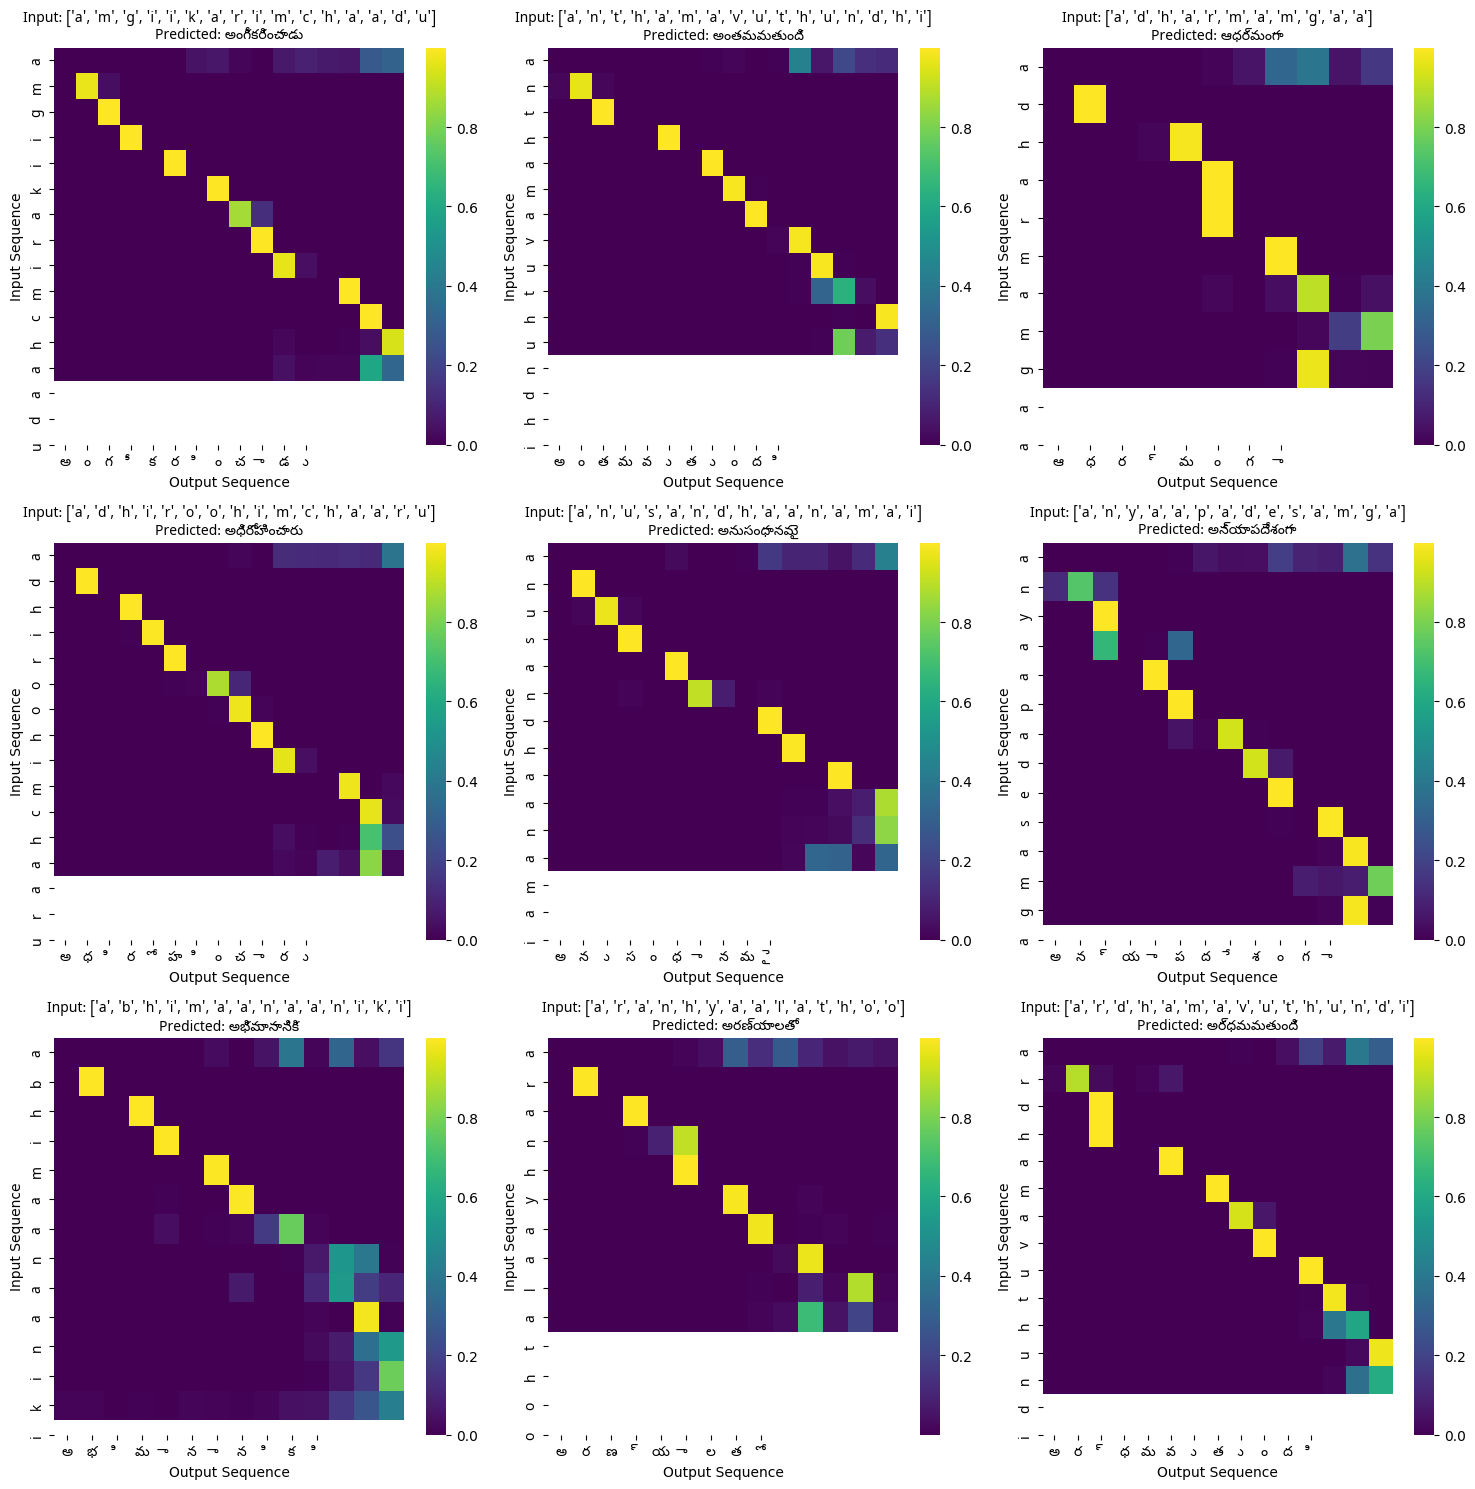

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# Function to decode indices into tokens, ignoring specified tokens
def decode_indices(indices, index_to_token, ignore_tokens):
    valid_indices = [index for index in indices if index not in ignore_tokens]  # Filter out the ignored tokens.
    return ''.join([index_to_token[index] for index in valid_indices if index in index_to_token])  # Convert indices to tokens and join them into a string.

# Function to plot attention weights using seaborn's heatmap
def plot_attention(ax, input_text, output_text, attention_weights, font_properties):
    attention_weights = attention_weights.squeeze(1)  # Remove singleton dimensions from attention weights.
    sns.heatmap(attention_weights, xticklabels=output_text, yticklabels=input_text, ax=ax, cmap='viridis')  # Plot the attention weights as a heatmap.
    ax.set_xticklabels(output_text, fontproperties=font_properties)  # Set telugu font for x-axis labels
    ax.set_yticklabels(input_text, fontproperties=font_properties)  # Set  trans font for y-axis labels
    ax.set_xlabel('Output Sequence')  # Set the x-axis label.
    ax.set_ylabel('Input Sequence')  # Set the y-axis label.
    title = f'Input: {input_text}\nPredicted: {predicted_text}'  # Combine input and predicted texts with a newline character
    ax.set_title(title, fontproperties=font_properties)  # Set the combined title

# Assume test_predictions are obtained from the predict function
test_predictions = predict(model, test_loader, device)  # Get predictions and attention weights from the model.

# Tokens to ignore during decoding
ignore_tokens = {
    tel_token_to_index['<eos>'],  # Ignore the <eos> token.
    tel_token_to_index['<pad>'],  # Ignore the <pad> token.
    tel_token_to_index['<sos>']  # Ignore the <sos> token.
}

# Load the Bengali font
tel_font_path = "/kaggle/input/telugu/static/NotoSansTelugu-Regular.ttf"  # Specify the path to a telugu font file
tel_font = fm.FontProperties(fname=tel_font_path, size=10)  # Create a font property

# Plotting in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Create a 3x3 grid of subplots with specified figure size.
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration.

for idx, (source_indices, target_indices, output_indices, attention_weights) in enumerate(test_predictions[:9]):  # Iterate over the first 9 test predictions.
    input_text = decode_indices(source_indices[0], trans_index_to_token, ignore_tokens)  # Decode the source indices into input text.
    predicted_text = decode_indices(output_indices[0], tel_index_to_token, ignore_tokens)  # Decode the output indices into predicted text.
    attention = attention_weights[0]  # Get the attention weights for the first sequence.
    
    plot_attention(axes[idx], list(input_text), list(predicted_text), attention, tel_font)  # Plot the attention weights.

# Hide any remaining empty subplots
for j in range(idx + 1, len(axes)):  # Iterate over any remaining subplots.
    fig.delaxes(axes[j])  # Delete the empty subplot.

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()  # Display the figure.